In [2]:
import sys
import os
import numpy as np

# Get the absolute path of the directory containing the current script/notebook.
script_dir = os.path.dirname(os.path.abspath("__file__"))

# Add this directory to sys.path
sys.path.append(script_dir)

# Now you can perform your import, without the leading dot
from atomphys.calc.rabi_frequency import dipole_Rabi_Frequency, quadrupole_Rabi_Frequency, Rabi_Frequency
from atomphys.electric_field import PlaneWaveElectricField, LaserField
from atomphys.plot import plot_atom
from atomphys.calc.hamiltonians import H0, H_int, collapse_operators
from atomphys.transition import Transition
from atomphys.load_data import load_from_database, from_nist
import qutip



In [3]:
Ca = from_nist('Ca')
u = Ca._ureg



Loading atom Ca
Added 783 states
Dropping 2 unmatched transitions
Added 135 transitions


In [4]:
Ca.states

[State(3p6.4s2 1S0 0 Ry),
 State(3p6.4s.4p 3P0 0.1381 Ry),
 State(3p6.4s.4p 3P1 0.1386 Ry),
 State(3p6.4s.4p 3P2 0.1396 Ry),
 State(3p6.3d.4s 3D1 0.1853 Ry),
 State(3p6.3d.4s 3D2 0.1854 Ry),
 State(3p6.3d.4s 3D3 0.1856 Ry),
 State(3p6.3d.4s 1D2 0.1991 Ry),
 State(3p6.4s.4p 1P1 0.2155 Ry),
 State(3p6.4s.5s 3S1 0.2874 Ry),
 State(3p6.4s.5s 1S0 0.3036 Ry),
 State(3p6.3d.4p 3F2 0.3256 Ry),
 State(3p6.3d.4p 3F3 0.3264 Ry),
 State(3p6.3d.4p 1D2 0.3266 Ry),
 State(3p6.3d.4p 3F4 0.3271 Ry),
 State(3p6.4s.5p 3P0 0.333 Ry),
 State(3p6.4s.5p 3P1 0.3331 Ry),
 State(3p6.4s.5p 3P2 0.3333 Ry),
 State(3p6.4s.5p 1P1 0.3347 Ry),
 State(3p6.4s.4d 1D2 0.3399 Ry),
 State(3p6.4s.4d 3D1 0.344 Ry),
 State(3p6.4s.4d 3D2 0.344 Ry),
 State(3p6.4s.4d 3D3 0.3441 Ry),
 State(3p6.3d.4p 3D1 0.348 Ry),
 State(3p6.3d.4p 3D2 0.3483 Ry),
 State(3p6.3d.4p 3D3 0.3486 Ry),
 State(3p6.4p2 3P0 0.3501 Ry),
 State(3p6.4p2 3P1 0.3505 Ry),
 State(3p6.4p2 3P2 0.3513 Ry),
 State(3p6.3d.4p 3P0 0.3584 Ry),
 State(3p6.3d.4p 3P1 0.3584

In [5]:
total_energy = Ca.get_state_by_term('1D2').energy+(405 * u('nm')).to('Ry', 'sp')+(390 * u('nm')).to('Ry', 'sp')

In [6]:
Ca.get_state_by_term('1D2').transitions

[Transition(3p6.3d.4s 1D2 --> 3p6.4s.6f 1F3 411 nm (E1)),
 Transition(3p6.3d.4s 1D2 --> 3p6.4s.5f 1F3 436 nm (E1)),
 Transition(3p6.3d.4s 1D2 --> 3p6.4s.4f 1F3 488 nm (E1)),
 Transition(3p6.3d.4s 1D2 --> 3p6.4s.6p 1P1 504 nm (E1)),
 Transition(3p6.3d.4s 1D2 --> 3p6.3d.4p 1F3 535 nm (E1)),
 Transition(3p6.3d.4s 1D2 --> 3p6.4s.5p 1P1 672 nm (E1))]

In [7]:
_3D3 = Ca.get_state_by_energy(Ca.get_state_by_term('1D2').energy+(391 * u('nm')).to('Ry', 'sp'))
_3D3


State(3p6.4s.10s 1S0 0.4323 Ry)

In [8]:
((_3D3.energy - Ca.get_state_by_term('1D2').energy).to('THz', 'sp') - (767.6911*u('THz')))

-0.5870698846021014 <Unit('terahertz')>

In [9]:
total_energy = Ca.get_state_by_term('1D2').energy+(405 * u('nm')).to('Ry', 'sp')
(390 * u('nm')).to('Ry', 'sp')

0.23365821809804802 <Unit('rydberg')>

In [ ]:
# (1) Define states of interest
_1S0 = Ca.get_state('1S0')
_1P1 =  Ca.get_state('1P1')
_1D2 = Ca.get_state_by_energy((_1P1.energy)+(733*u('nm')).to('Ry', 'sp'))
states = [_1S0, _1P1, _1D2]

# (2) Define your lasers
_1S0to_1P1 = Ca.transition_between(_1S0, _1P1)
_1P1to_1D2 = Ca.transition_between(_1P1, _1D2)

pow_blue = 1*u('mW')
pow_red = 1*u('mW')
w_blue = 1*u('mm')
w_red = 1*u('mm')

det_blue = 0*u('MHz')
det_red = 0*u('MHz')

_423nm_laser = LaserField(polarization=np.array([0,0,1]), direction_of_propagation=np.array([0,1,0]), frequency = _1S0to_1P1.frequency, power=pow_blue, waist=w_blue, detuning=det_blue, _ureg=u)
_733nm_laser = LaserField(polarization=np.array([0,0,1]), direction_of_propagation=np.array([0,1,0]), frequency = _1P1to_1D2.frequency, power=pow_red, waist=w_red, detuning=det_red, _ureg=u)

# (3) Define which lasers connect which transitions
lasers = {_423nm_laser: [_1S0to_1P1], _733nm_laser: [_1P1to_1D2]}

# (4) Calculate the Hamiltonian and Jump operators
H = H0(Ca, states, u) + H_int(Ca, states, lasers, u)
co = collapse_operators(Ca, states, u)

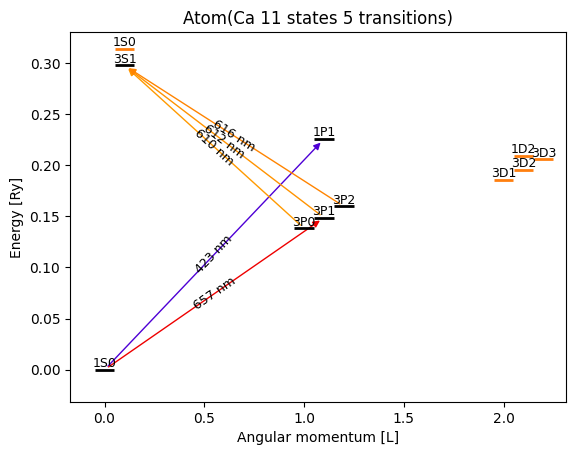

In [6]:
plot_atom(Ca, max_energy=0.32*u('Ry'), introduce_offset=True)

In [4]:
# (1) Define states of interest
_1S0 = Ca.get_state('1S0')
_1P1 =  Ca.get_state('1P1')
_1D2 = Ca.get_state_by_energy((_1P1.energy)+(733*u('nm')).to('Ry', 'sp'))
states = [_1S0, _1P1, _1D2]

# (2) Because NIST is not complete, add transitions that are missing
Gamma_4s4d = 1.4*1e7 * u('Hz')
_1P1to_1D2 = Transition(state_i=_1P1, state_f=_1D2, A=Gamma_4s4d, _ureg=u)
Ca.add_transition(_1P1to_1D2)

# (3) Define your lasers

_1S0to_1P1 = Ca.transition_between(_1S0, _1P1)
_1P1to_1D2 = Ca.transition_between(_1P1, _1D2)

pow_blue = 1*u('mW')
pow_red = 1*u('mW')
w_blue = 1*u('mm')
w_red = 1*u('mm')

det_blue = 0*u('MHz')
det_red = 0*u('MHz')

_423nm_laser = LaserField(polarization=np.array([0,0,1]), direction_of_propagation=np.array([0,1,0]), frequency = _1S0to_1P1.frequency, power=pow_blue, waist=w_blue, detuning=det_blue, _ureg=u)
_733nm_laser = LaserField(polarization=np.array([0,0,1]), direction_of_propagation=np.array([0,1,0]), frequency = _1P1to_1D2.frequency, power=pow_red, waist=w_red, detuning=det_red, _ureg=u)

# (4) Define which lasers connect which transitions
lasers = {_423nm_laser: [_1S0to_1P1], _733nm_laser: [_1P1to_1D2]}

# (5) Calculate the Hamiltonian and Jump operators
H = H0(Ca, states, u) + H_int(Ca, states, lasers, u)
co = collapse_operators(Ca, states, u)










In [5]:
H

Quantum object: dims = [[9], [9]], shape = (9, 9), type = oper, isherm = True
Qobj data =
[[0.00000000e+00 0.00000000e+00 4.58352752e+01 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 2.51454714e+01 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [4.58352752e+01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 2.90354894e+01 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 2.51454714e+01
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  9.53674316e-07 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 2.51454714e+01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 9.53674316e-07 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.90354894e+01 0.00000000e

In [36]:

qutip.steadystate(H, co)

Quantum object: dims = [[9], [9]], shape = (9, 9), type = oper, isherm = True
Qobj data =
[[ 3.97669917e-01+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   1.53998411e-09+1.30385414e-01j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   2.29703315e-01+1.92704711e-09j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  7.84050465e-03+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j -2.42759938e-11+1.03178510e-03j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j]
 [ 1.53998411e-09-1.30385414e-01j  0.00000000e+00+0.00000000e+00j
   1.48802972e-01+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   3.62721423e-09-6.15475825e-02j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j]
 [ 0.00000000

In [9]:
import numpy as np
p_1, p_2, p_3 = [], [], []
dets = np.linspace(-40, 40, 100)

for det in dets:
    det_red = 0*u('MHz')
    det_blue = det*u('MHz')
    pow_blue = 0.5*u('mW')
    pow_red = 2*u('mW')
    w_blue = 1*u('mm')
    w_red = 1*u('mm')

    _423nm_laser = LaserField(polarization=np.array([0,0,1]), direction_of_propagation=np.array([1,0,0]), frequency = _1S0to_1P1.frequency, power=pow_blue, waist=w_blue, detuning=det_blue, _ureg=u)
    _733nm_laser = LaserField(polarization=np.array([0,0,1]), direction_of_propagation=np.array([0,1,0]), frequency = _1P1to_1D2.frequency, power=pow_red, waist=w_red, detuning=det_red, _ureg=u)

    lasers = {_423nm_laser: [_1S0to_1P1], _733nm_laser: [_1P1to_1D2]}
    H = H0(Ca, states, u) + H_int(Ca, states, lasers, u)
    ss = qutip.steadystate(H, co)
    p_1.append(ss[0,0])
    p_2.append(ss[2,2])
    p_3.append(ss[6,6])


Text(0, 0.5, 'Population')

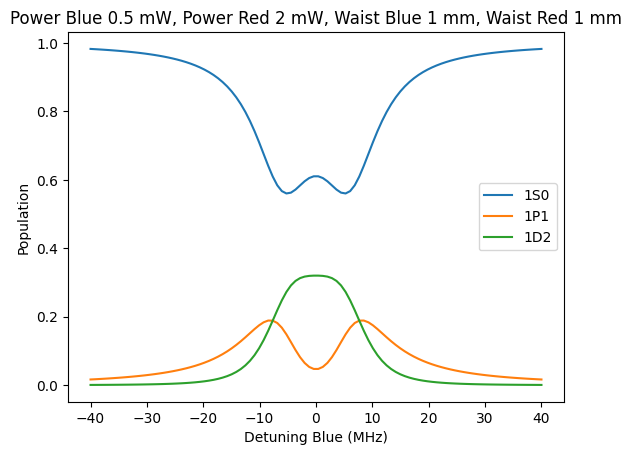

In [11]:
import matplotlib.pyplot as plt
plt.plot(dets, p_1, label='1S0')
plt.plot(dets, p_2, label='1P1')
plt.plot(dets, p_3, label='1D2')
plt.legend()
plt.title(f'Power Blue {pow_blue}, Power Red {pow_red}, Waist Blue {w_blue}, Waist Red {w_red}')
plt.xlabel('Detuning Blue (MHz)')
plt.ylabel('Population')

In [15]:
import qutip as qt

result2 = qt.steadystate(H, c_op_list=co)
#qutip.steadystate(H0(Ca, states, u) + H_int_graph(Ca, states, lasers, u), method='direct')

In [16]:
result2

Quantum object: dims = [[9], [9]], shape = (9, 9), type = oper, isherm = True
Qobj data =
[[ 9.99999994e-01+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   4.32097305e-08+1.44418410e-09j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   7.05969353e-05+8.53060609e-12j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  9.77080096e-11+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j -5.43028266e-23+2.30799397e-15j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j]
 [ 4.32097305e-08-1.44418410e-09j  0.00000000e+00+0.00000000e+00j
   3.80709561e-10+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   3.05047459e-12-1.09742618e-13j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j]
 [ 0.00000000

In [17]:
Ca_ion = from_nist('Ca+')
u_ion = Ca_ion._ureg
Ca_ion_truncated = Ca_ion.remove_states_above_energy(0.23*u_ion('Ry'), copy=False)

Loading atom Ca+
Added 72 states
Added 99 transitions


In [18]:
arr = [0,1,2,3,4,5,6,7,8,9,10]

In [19]:
arr[-0]

0

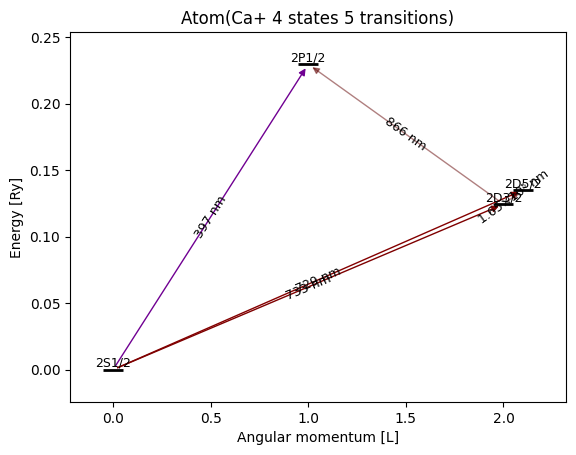

In [20]:
plot_atom(Ca_ion_truncated, introduce_offset=True)

In [21]:
states_ion = Ca_ion_truncated.states
_S1_2 = Ca_ion_truncated.get_state('2S1/2')
_D3_2 = Ca_ion_truncated.get_state('2D3/2')
_D5_2 = Ca_ion_truncated.get_state('2D5/2')
_P1_2 = Ca_ion_truncated.get_state('2P1/2')

_2S1_2to_2D3_2 = Ca_ion_truncated.transition_between(_S1_2, _D3_2)
_2D3_2to_2P1_2 = Ca_ion_truncated.transition_between(_D3_2, _P1_2)

_729nm_laser = LaserField(polarization=np.array([1,0,0]), direction_of_propagation=np.array([0,0,1]), frequency = _2S1_2to_2D3_2.frequency, power=10*u_ion('mW'), waist=1*u_ion('mm'), _ureg=u_ion)
_866nm_laser = LaserField(polarization=np.array([1,0,0]), direction_of_propagation=np.array([0,0,1]), frequency = _2D3_2to_2P1_2.frequency, power=10*u_ion('mW'), waist=1*u_ion('mm'), _ureg=u_ion)

lasers = {_729nm_laser: [_2S1_2to_2D3_2], _866nm_laser: [_2D3_2to_2P1_2]}

In [22]:
H0(Ca_ion, states_ion, u_ion) + H_int_graph(Ca_ion, states_ion, lasers, u_ion)

NameError: name 'H_int_graph' is not defined

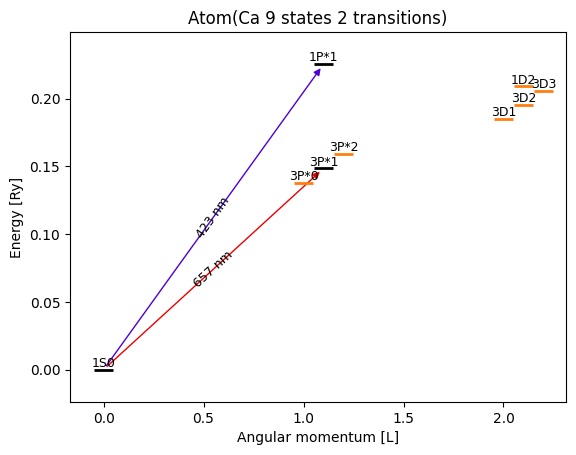

In [ ]:
plot_atom(Ca_removed, introduce_offset=True)

In [ ]:
states = Ca.states

In [ ]:
import pint

In [ ]:
u = pint.UnitRegistry()

In [ ]:


my_kg = 1*u('kg')
in_gram = my_kg.to('g')
in_gram

1000.0 <Unit('gram')>

In [ ]:
delta_omega = 1.57 * u('GHz') * 2*np.pi
lam = 423 * u('nm')
k = 2*np.pi/lam
cos_theta = 1/2
v_th = delta_omega/(2*cos_theta*k)
m = 40 * u('amu')
T = v_th**2*m/(u('k_B')*3)


In [ ]:
T.to('degC')

434.1189476200884 <Unit('degree_Celsius')>

In [ ]:
u = tr._ureg
A = tr.A
k = tr.k
J_i = tr.state_i.quantum_numbers['J']
J_f = tr.state_f.quantum_numbers['J']
mJ_i = J_i
mJ_f = J_f

E0 = 1*u('V/m')
polarization = np.array([1, 0, 0])
wavevector = np.array([0, 0, 1])
frequency = 800*u('THz')



E = PlaneWaveElectricField(E0, polarization, wavevector, frequency, _ureg=u)

El_field =E.field(1*u('nm'),0*u('nm'),1*u('nm'))

#quadrupole_matrix_element(A, k, J_i, J_f, mJ_i, mJ_f, u).to('a0**2')

dipole_Rabi_Frequency(El_field, A, k, J_i, J_f, mJ_i, mJ_f, u).to('MHz')


ValueError: Cannot operate with Quantity and Quantity of different registries.

In [ ]:
import pint
from atomphys.electric_field import PlaneWaveElectricField
import numpy as np



In [ ]:
(x, y, z) = (0*u('nm'), 0*u('nm'), 0*u('nm'))

E.gradient(x, y, z)



Magnitude,[[0.+0.j 0.+0.j 0.+0.j ] [0.+0.j 0.+0.j 0.+0.j ] [0.+0.01676676j 0.+0.j 0.+0.j ]]
Units,V/(m nm)


In [ ]:
Sr = from_nist('Sr')
u_sr = Sr._ureg

Loading atom Sr
Added 380 states
Added 361 transitions


In [ ]:
_1S0 = Sr.get_state('1S0')
_1P1 =  Sr.get_state('1P1')
_1D2 = Sr.get_state_by_energy((_1P1.energy)+(766*u_sr('nm')).to('Ry', 'sp'))


In [ ]:
Sr.get_state_by_energy((_1D2.energy)+(810*u_sr('nm')).to('Ry', 'sp'))

State(5p2 1D2 0.4226 Ry)

In [ ]:
(u_sr('planck_constant*c')/(813*u_sr('nm'))).to('Ry')

0.11208696809131455 <Unit('rydberg')>

In [ ]:
Sr.states

[State(5s2 1S0 0 Ry),
 State(5s.5p 3P0 0.1305 Ry),
 State(5s.5p 3P1 0.1322 Ry),
 State(5s.5p 3P2 0.1358 Ry),
 State(5s.4d 3D1 0.1655 Ry),
 State(5s.4d 3D2 0.166 Ry),
 State(5s.4d 3D3 0.1669 Ry),
 State(5s.4d 1D2 0.1836 Ry),
 State(5s.5p 1P1 0.1977 Ry),
 State(5s.6s 3S1 0.2646 Ry),
 State(5s.6s 1S0 0.2788 Ry),
 State(4d.5p 3F2 0.3031 Ry),
 State(4d.5p 3F3 0.3061 Ry),
 State(4d.5p 1D2 0.3083 Ry),
 State(5s.6p 3P0 0.3085 Ry),
 State(5s.6p 3P1 0.3086 Ry),
 State(4d.5p 3F4 0.3091 Ry),
 State(5s.6p 3P2 0.3096 Ry),
 State(5s.6p 1P1 0.3107 Ry),
 State(5s.5d 1D2 0.3165 Ry),
 State(5s.5d 3D1 0.319 Ry),
 State(5s.5d 3D2 0.3191 Ry),
 State(5s.5d 3D3 0.3194 Ry),
 State(5p2 3P0 0.3207 Ry),
 State(5p2 3P1 0.3226 Ry),
 State(5p2 3P2 0.3251 Ry),
 State(4d.5p 3D1 0.3305 Ry),
 State(4d.5p 3D2 0.3315 Ry),
 State(4d.5p 3D3 0.3332 Ry),
 State(4d2 1D2 0.3368 Ry),
 State(5p2 1S0 0.3386 Ry),
 State(4d.5p 3P0 0.3398 Ry),
 State(4d.5p 3P1 0.3399 Ry),
 State(4d.5p 3P2 0.3402 Ry),
 State(5s.7s 3S1 0.341 Ry),
 Stat

In [ ]:
import pandas as pd
states_pd = pd.DataFrame(states, columns=['F', 'J', 'mJ', 'state_number'])

In [ ]:
get_mJ_to_index_map(0.5, 1.5)

{-1.5: 0.0, -0.5: 1.0, 0.5: 2.0, 1.5: 3.0}

In [ ]:
results

[(0.5, 1.5, 0.0),
 (0.5, 0.5, 0.08258083),
 (0.5, 2.5, 0.08258083),
 (1.5, 1.5, 0.0),
 (1.5, 0.5, 0.03395514),
 (1.5, 2.5, 0.0)]

In [ ]:
results = []
for F in unique_F:
    for J in unique_J:
        ind_map = get_mJ_to_index_map(F, J)
        for mJ in ind_map.keys():
            acc = 0
            acc+= microwave_transition_matrix[int(ind_map[mJ]),1]
        results.append((F, J, acc))

In [ ]:
results

[(0.5, 1.5, 0.0),
 (0.5, 0.5, 0.0),
 (0.5, 2.5, 0.0),
 (1.5, 1.5, 0.2668718),
 (1.5, 0.5, 0.0),
 (1.5, 2.5, 0.0)]

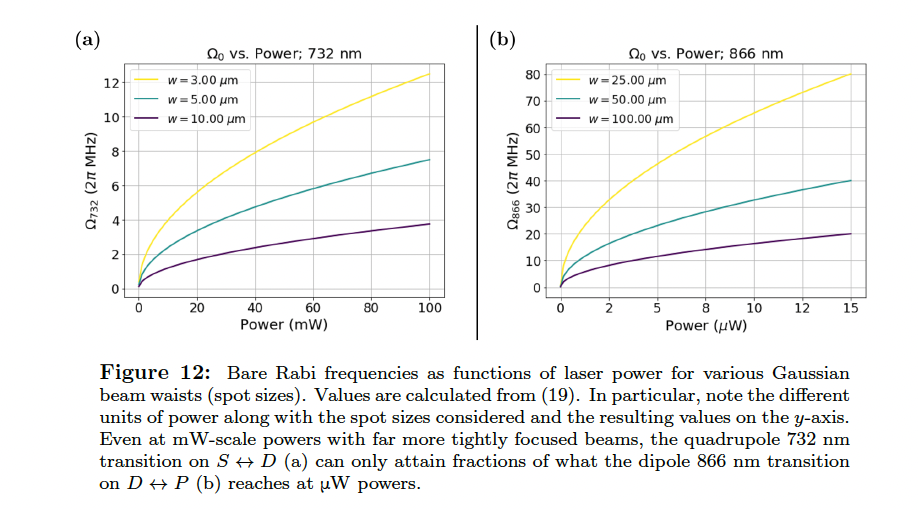

In [ ]:
Ca_ion = from_nist('Ca+')
u_ion = Ca_ion._ureg
Ca_ion_truncated = Ca_ion.remove_states_above_energy(0.23*u_ion('Ry'), copy=False)

Loading atom Ca+
Added 72 states
Added 99 transitions
Removed 68 states above 0.23 Ry


In [ ]:

_S1_2 = Ca_ion_truncated.get_state('2S1/2')
_D3_2 = Ca_ion_truncated.get_state('2D3/2')
_D5_2 = Ca_ion_truncated.get_state('2D5/2')
_P1_2 = Ca_ion_truncated.get_state('2P1/2')

_2S1_2to_2D3_2 = Ca_ion_truncated.transition_between(_S1_2, _D3_2)
_2D3_2to_2P1_2 = Ca_ion_truncated.transition_between(_D3_2, _P1_2)

waist = 3*u_ion('um')
power  = 1*u_ion('uW')
_866nm_laser = LaserField(polarization=np.array([0,0,1]), direction_of_propagation=np.array([1,0,0]), frequency = _2D3_2to_2P1_2.frequency, power=power, waist=waist, _ureg=u_ion)
#_866nm_laser = LaserField(polarization=np.array([0,0,1]), direction_of_propagation=np.array([1,0,0]), frequency = _2D3_2to_2P1_2.frequency, power=10*u_ion('mW'), waist=1*u_ion('mm'), _ureg=u_ion)



In [ ]:
_2S1_2to_2D3_2.state_f.quantum_numbers['J']



1.5

In [ ]:
0.5*2+1
from sympy.physics.wigner import wigner_3j as w3j


In [ ]:
np.sqrt(5*(1.5*2+1)) * w3j(0.5,2, 1.5, 0, 0, 0)

-0.447213595499958*sqrt(5)

In [ ]:
_733nm_laser.gradient()

Magnitude,[[0.+0.00000000e+00j 0.+0.00000000e+00j 0.+3.74557725e+15j] [0.+0.00000000e+00j 0.+0.00000000e+00j 0.+0.00000000e+00j] [0.+0.00000000e+00j 0.+0.00000000e+00j 0.+0.00000000e+00j]]
Units,µW0.5/(c1.5 s µm ε_00.5)


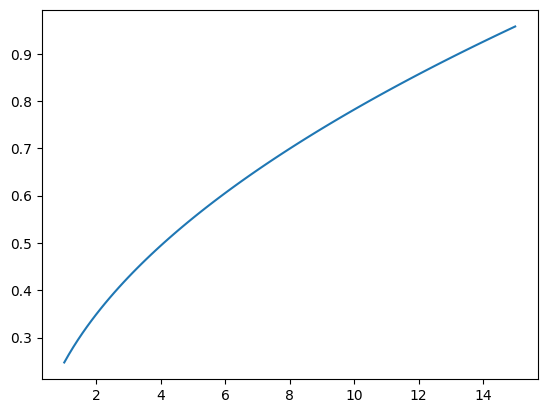

In [ ]:
import matplotlib.pyplot as plt
waist = 3*u_ion('um')
powers = np.linspace(1, 15, 100) * u_ion('mW')
RF = []
fields = []
for power in powers:
    _733nm_laser = LaserField(polarization=np.array([0,-1,1]), direction_of_propagation=np.array([0,1,1]), frequency = _2S1_2to_2D3_2.frequency, power=power, waist=waist, _ureg=u_ion)
    fields.append(_733nm_laser.field().magnitude)
    RF.append(abs((Rabi_Frequency(transition = _2S1_2to_2D3_2, E_field=_733nm_laser, mJ_i=0, mJ_f=0, _ureg=u_ion).to('MHz')).magnitude/2/np.pi))

plt.plot(powers, RF)


In [ ]:
from atomphys.calc.matrix_element import dipole_matrix_element, quadrupole_matrix_element

In [ ]:
_2S1_2to_2D3_2.state_f

State(3p6.3d 2D3/2 0.1244 Ry)

In [ ]:
k = _2D3_2to_2P1_2.k
A = _2D3_2to_2P1_2.A
J_i = _2D3_2to_2P1_2.state_i.quantum_numbers['J']
J_f = _2D3_2to_2P1_2.state_f.quantum_numbers['J']
dipole_matrix_element(A=A, k=k,J_i=J_i, J_f=J_f, mJ_i=0, mJ_f=0, _ureg=u_ion).to('a0')

Magnitude,[0 0 -0.434810900633458*sqrt(3)]
Units,a_0


In [ ]:
_2D3_2to_2P1_2.state_f

State(3p6.4p 2P1/2 0.2296 Ry)

In [ ]:
k = _2S1_2to_2D3_2.k
A = _2S1_2to_2D3_2.A
J_i = _2S1_2to_2D3_2.state_i.quantum_numbers['J']
J_f = _2S1_2to_2D3_2.state_f.quantum_numbers['J']
quadrupole_matrix_element(A=A, k=k,J_i=J_i, J_f=J_f, mJ_i=0, mJ_f=0, _ureg=u_ion).to('a0**2')